In [503]:
import numpy as np
import matplotlib.pyplot as plt

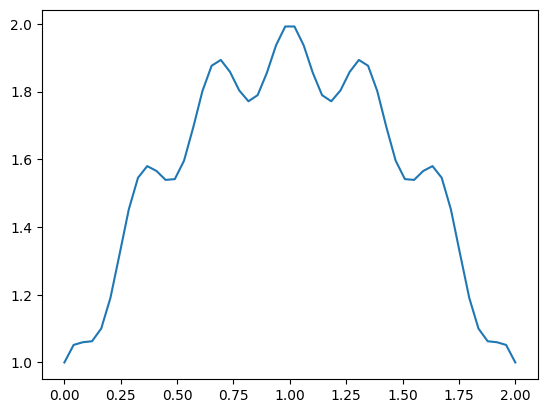

In [504]:

def f(x):
    return -(0.1 + (1-x)**2 - 0.1*np.cos(6*np.pi*(1-x))) + 2


x = np.linspace(0, 2, 50)
y = f(x)

plt.plot(x, y)



In [505]:
# FUNCION PARA INICIAR POBLACION
def iniciar_población(numero_individuos, longitud_cromosoma):
    return  np.random.randint(0,2,size=(numero_individuos,longitud_cromosoma))

In [506]:
# FUNCIÓN PARA DECODIFICAR DE BINARIO A DECIMAL LOS INDIVIDUOS
def decodificar(poblacion, min, max):
    [renglones,columnas] = poblacion.shape
    decimal = np.zeros(renglones)
    decimal_rescalado = np.zeros(renglones)
    
    for i in range(renglones):
        for j in range(columnas):
            # Se transforma de binario a decimal entero
            decimal[i] += poblacion[i,j]*2**(columnas-j-1)
            
            # Se rescalan los valores al rango de busqueda
            decimal_rescalado[i] = (max-min)*decimal[i]/(2**columnas-1) + min
            
    return decimal_rescalado



In [507]:
# FUNCIÓN PARA OBTENER LAS APTITUDES (FITNESS) DE CADA INDIVIDUO

def fitness(poblacion, min, max):
    [renglones,columnas] = poblacion.shape
    x = decodificar(poblacion,min,max)
    fitness = -(0.1 + (1-x)**2 - 0.1*np.cos(6*np.pi*(1-x))) + 2
    return fitness

In [508]:
# FUNCIÓN DE CRUZAMIENTO (SINGLE POINT)
def cruzamiento(poblacion,pares_de_cromosomas:int):
    [renglones,columnas] = poblacion.shape
    if pares_de_cromosomas > renglones/2:
        raise ValueError("El numero de pares de cromosomas debe ser menor a la mitad del numero de individuos")
    M = np.zeros((2*pares_de_cromosomas,columnas)) # Matriz de hijos
    for i in range(pares_de_cromosomas):
        r1 = np.random.randint(0,renglones,size=(1,2)) # Par de numeros aleatorios para seleccionar padres
        r2 = np.random.randint(0,columnas) # Punto de cruzamiento
        
        # Selecionamos los padres a cruzar

        
        padre_1 = poblacion[r1[0,0],:]
        padre_2 = poblacion[r1[0,1],:]
        
        # Se crean los hijos
        hijo_1 = np.concatenate((padre_1[0:r2], padre_2[r2:]))
        hijo_2 = np.concatenate((padre_2[0:r2], padre_1[r2:]))
        
        # Guardar a mis hijos
        M[2*i,:] = hijo_1
        M[2*i+1,:] = hijo_2
    return M


        
        

In [509]:
# FUNCIÓN QUE HACE LA REPRESENTACIÓN DE MUTACIÓN DE CROMOSOMAS
def mutacion(poblacion,tasa_mutacion):
    [renglones,columnas] = poblacion.shape
    n = int(tasa_mutacion*columnas)
    for i in range(n):
        individuo_rand = np.random.randint(0,renglones) # Selecciona un individuo al azar
        gen_rand = np.random.randint(0,columnas) # Selecciona un gen al azar

        match poblacion[individuo_rand,gen_rand]:
            case 0:
                poblacion[individuo_rand,gen_rand] = 1
            case 1:
                poblacion[individuo_rand,gen_rand] = 0
                    
    return poblacion


In [510]:
# FUNCIÓN DE SELECCIÓN POR ORDEN LINEAL (RANKING)
def seleccion_ranking(poblacion, porcentaje_seleccion,min,max):
    [renglones,columnas] = poblacion.shape
    nueva_poblacion = np.zeros((renglones,columnas))
    n = int(porcentaje_seleccion*renglones)
    aptitud = fitness(poblacion,min,max).reshape(renglones,1)
    poblacion_ampliada = np.concatenate([poblacion,aptitud],axis=1)
    indices = np.argsort(poblacion_ampliada[:,-1])[::-1]
    poblacion_ordenada = poblacion_ampliada[indices]
    poblacion_seleccionada = poblacion_ordenada[:n,:]
    poblacion_ordenada_final = poblacion_seleccionada[:,0:columnas]
    
    for r in range(renglones):
        for c in range(columnas):
            # Rellena la nueva población con los mejores individuos y el resto con individuos aleatorios
            if r < n:
                nueva_poblacion[r,c] = poblacion_ordenada_final[r,c]
            else:
                nueva_poblacion[r,c] = np.random.randint(0,2)
                
    return nueva_poblacion


In [511]:
# SELECCION POR TORNEO

# Seleccion por torneo
def seleccion_torneo(poblacion, Imin, Imax,k : int):
  '''
  poblacion: poblacion de individuos en binario
  k: Tamanio del torneo
  '''
  [r,c] = poblacion.shape
  aptitud = fitness(poblacion, Imin, Imax).reshape(r,1)
  M = np.concatenate([poblacion,aptitud],axis=1)
  
  # Seleccionamos los k individuos
  indices = np.random.choice(r,size=k,replace=False)
  torneo = M[indices,:]
  # Ordenamos ppor aptitud descendente
  indices = np.argsort(torneo[:,-1])[::-1]
  torneo_ordenado = torneo[indices]
  # Seleccionamos el mejor individuo
  mejor_individuo = torneo_ordenado[0,0:c]
  return mejor_individuo


# FUNCION QUE CREA UNA NUEVA POBLACION A PARTIR DEL TORNEO
def nueva_poblacion_torneo(poblacion, k:int,min,max):
    [renglones,columnas] = poblacion.shape
    nueva_poblacion = np.zeros((renglones,columnas))
    
    # Se repite el torneo
    for i in range(renglones):
        nueva_poblacion[i,:] = seleccion_torneo(poblacion,k,min,max)
    return nueva_poblacion
    

In [512]:
# SELECCION POR RULETA
def seleccion_ruleta(poblacion,min,max):
    [renglones,columnas] = poblacion.shape
    aptitud = fitness(poblacion,min,max)
    min_fitness = np.min(aptitud)
    
    if (min_fitness < 0):
        aptitud = aptitud - min_fitness + 1e-6
    if (np.sum(aptitud) == 0):
        probabilidad = np.ones(renglones)/renglones
    else:
        probabilidad = aptitud/np.sum(aptitud)
    
    # Obtenemos las probabilidades acumuladas
    acumuladas = np.cumsum(probabilidad)
    # Generamos un random num para simular la rotación de la ruleta
    num = np.random.rand()

    # Se busca el individuo donde cae el número aleatorio
    for i in range(renglones):
        if num < acumuladas[i]:
            ganador = poblacion[i,:]
            break
    return ganador


# Nueva población por ruleta
def nueva_poblacion_ruleta(poblacion,min,max):
    [renglones,columnas] = poblacion.shape
    nueva_poblacion = np.zeros((renglones,columnas))

    for i in range(renglones):
        nueva_poblacion[i,:] = seleccion_ruleta(poblacion,min,max)
    return nueva_poblacion

In [513]:
# IMPLEMENTACIÓN
print("IMPLEMENTACIÓN")


# ================== PARAMETROS DE ARRANQUE ==================
numero_individuos = 10
longitud_cromosoma = 8
generaciones = 100
porcentaje_seleccion = 0.6
par_cromosomas = int(numero_individuos/2)
tasa_mutacion = 0.05 # Esto requiere ser un valor entre bajo
min = 0
max = 2
tamaño_torneo=3
tipo_seleccion="torneo"


# ================== ALGORITMO GENÉTICO ==================

# PASO 1 | Creamos la población
poblacion = iniciar_población(numero_individuos,longitud_cromosoma)
print(f"[PASO 1] Población inicial: \n{poblacion}\n")


for i in range(generaciones):
    print(f"========= Generación {i+1}\n")
    # Paso 2 | Aplicamos el cruzamiento
    cruza = cruzamiento(poblacion,par_cromosomas)
    print(f"[PASO 2] Población después del cruzamiento: \n{cruza[:5]}\n")

    # Paso 3 | Aplicamos la mutación
    mutados = mutacion(cruza,tasa_mutacion)
    print(f"[PASO 3] Población después de la mutación: \n{mutados}\n")

    # Paso 4 | Selección de la nueva generación
    #seleccion = seleccion_ranking(mutados,porcentaje_seleccion,min,max)
    #seleccion = nueva_poblacion_torneo(mutados, k=tamaño_torneo, min=min, max=max)
    seleccion = nueva_poblacion_ruleta(mutados, min=min, max=max)
    print(f"[PASO 4] Población de la nueva generación: \n{seleccion}\n")

    poblacion = seleccion

# ================= RESULTADOS =================
poblacion_mejor = decodificar(poblacion, min, max)
individuo_mejor = poblacion_mejor[0]
print(f"El mejor individuo es: {individuo_mejor}")
print(f"El gen es: {poblacion[0,:]}")

# TODO hacer un graficador de empalmar el mejor valor de aptitud o un historico para ver como progresa la aptitud


IMPLEMENTACIÓN
[PASO 1] Población inicial: 
[[0 0 1 0 1 0 1 0]
 [0 1 0 1 1 0 1 1]
 [0 1 0 1 1 0 0 1]
 [1 1 0 0 0 0 0 1]
 [0 0 1 1 0 1 0 0]
 [1 1 0 1 1 1 1 0]
 [0 0 0 1 1 1 0 0]
 [1 0 0 1 1 1 1 1]
 [0 0 1 0 1 1 1 1]
 [1 0 1 0 1 0 1 1]]

========= Generación 1

[PASO 2] Población después del cruzamiento: 
[[1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1.]]

[PASO 3] Población después de la mutación: 
[[1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1. 0. 0. 1.]]

[PASO 4] Población de la nueva generación: 
[[1. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 1.]
 [0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 1. 0. 1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 0. 1. 0. 0.]
 [1. 0. 1

# ALGORITMO GENÉTICO REPRESENTACIÓN REAL

In [514]:
# FUNCIÓN PARA INICIAR POBLACION REAL
def iniciar_poblacion(numero_individuos, longitud_cromosoma, min, max):
    poblacion = np.random.uniform(min, max, size=(numero_individuos,longitud_cromosoma))
    return poblacion

In [515]:
# FUNCIÓN PARA OBTENER LAS APTITUDES (FITNESS) DE CADA INDIVIDUO REAL
def fitness_real(poblacion):
    x = poblacion
    fitness = -(0.1 + (1-x)**2 - 0.1*np.cos(6*np.pi*(1-x))) + 2
    return fitness

In [ ]:
# CRUZA REAL
def cruza_real(poblacion,porcentaje_cruza,min,max):
    [renglones,columnas] = poblacion.shape
    # Número de hijos a generar según el porcentaje (asegurar par)
    n_hijos = int(renglones * porcentaje_cruza)
    if n_hijos % 2 != 0:
        n_hijos -= 1
    n_cruces = n_hijos // 2

    print(f"Tamaño de la población: {poblacion.shape}")
    print(f"Número de cruces a realizar: {n_cruces}")
    print(f"Número de hijos a generar: {n_hijos}")

    # Nueva población del mismo tamaño que la original
    M = np.zeros((renglones, 1))
    print(f"Tamaño de la matriz de hijos: {M.shape}")
    
    
    # TODO: Quiza se pueda sacar o declarar esta matriz en zeros para reserver y consumir menos memoria
    for i in range(n_cruces):
        # Selecciona dos padres (mejor sin reemplazo)
        idx1, idx2 = np.random.choice(renglones, size=2, replace=False)
        padre_1 = poblacion[idx1, 0]
        padre_2 = poblacion[idx2, 0]

        alpha = np.random.rand()

        hijo_1 = alpha*padre_1 + (1-alpha)*padre_2
        hijo_2 = alpha*padre_2 + (1-alpha)*padre_1

        # Limitar al espacio de búsqueda
        hijo_1 = np.clip(hijo_1, min, max)
        hijo_2 = np.clip(hijo_2, min, max)

        # Guardar descendientes
        M[2*i, 0] = hijo_1
        M[2*i+1, 0] = hijo_2

    # Rellenar el resto (si el porcentaje no cubre toda la población)
    if 2*n_cruces < renglones:
        M[2*n_cruces:, 0] = np.random.uniform(min, max, size=(renglones - 2*n_cruces,))

    return M


In [ ]:
# MUTACION REAL
def mutacion_real(poblacion, tasa_mutacion, min, max, beta=0.05):
    [renglones, columnas] = poblacion.shape
    sigma = beta * (max - min)
    n = int(np.ceil(tasa_mutacion*renglones))
    
    # Genear la lista de individuos a mutar para despues mutarlos de una vez
    for i in range(n):
        r1 = np.random.randint(0,renglones)
        N = np.random.normal(0,sigma)
        poblacion[r1,0] += N
        poblacion[r1,0] = np.clip(poblacion[r1,0], min, max)
        
    return poblacion


In [ ]:
# SELECCION POR RANKING
# FUNCIÓN DE SELECCIÓN POR ORDEN LINEAL (RANKING)
def seleccion_ranking_real(poblacion, porcentaje_seleccion,min,max):
    [renglones,columnas] = poblacion.shape
    
    nueva_poblacion = np.zeros((renglones,columnas))
    n = int(porcentaje_seleccion*renglones)
    
    # TODO: Sacar el fitness fuera de la función ==============================
    aptitud = fitness_real(poblacion).reshape(renglones,1)
    poblacion_ampliada = np.concatenate([poblacion,aptitud],axis=1)
    
    # TODO: Se puede sub ordenar los conjuntos y después organizarlos
    indices = np.argsort(poblacion_ampliada[:,-1])[::-1]
    poblacion_ordenada = poblacion_ampliada[indices]
    poblacion_seleccionada = poblacion_ordenada[:n,:]
    poblacion_ordenada_final = poblacion_seleccionada[:,0:columnas]
    # =========================================================================
    
    
    for r in range(renglones):
            # Rellena la nueva población con los mejores individuos y el resto con individuos aleatorios
        if r < n:
            nueva_poblacion[r] = poblacion_ordenada_final[r]
        else:
            nueva_poblacion[r] = np.random.uniform(min, max)

    return nueva_poblacion


In [ ]:
# IMPLEMENTACIÓN
print("IMPLEMENTACIÓN")


# ================== PARAMETROS DE ARRANQUE ==================
numero_individuos = 100
longitud_cromosoma = 1
generaciones = 50
porcentaje_seleccion = 0.6
porcentaje_cromosomas = 0.5
tasa_mutacion = 0.05 # Esto requiere ser un valor entre bajo
min = -2
max = 2
tamaño_torneo=3
tipo_seleccion="torneo"


poblacion = iniciar_poblacion(numero_individuos,longitud_cromosoma,min,max)
# TODO: Puede ser que la población se pueda separar y despues concatenar, vemos si se puede hacer tiempo atras...

print(f"Poblacion Real: \n{poblacion}\n")
# ================== ALGORITMO GENÉTICO ==================
for gen in range(generaciones):
    # Cruzamos
    cruza = cruza_real(poblacion, porcentaje_cromosomas, min, max)
    # TODO: Sacar el fitness fuera de la función iria aquí
    print(f"end=> Cruza Real: \n{cruza}\n")
    
    # Seleccionamos
    poblacion = seleccion_ranking_real(cruza, porcentaje_seleccion, min, max)
    
    print(f"end=> Selección por Ranking: \n{poblacion}\n")

    # Mutamos
    poblacion = mutacion_real(poblacion, tasa_mutacion, min, max)
    # TODO: Podemos mutarlo sin necesidad de tener la población completa, podriamos mutar un rango y ya se que este completo ese rango o no mutamos da igual que sea...
    print(f"end=> Mutación Real: \n{poblacion}\n")



x_mejor = poblacion[0,0]
print("RESULTADOS")
print(f"Población Final: \n{poblacion}\n")
print(f"Mejor Individuo: {x_mejor}\n")



IMPLEMENTACIÓN
Poblacion Real: 
[[-1.61468088]
 [ 0.0131299 ]
 [-1.226964  ]
 [ 1.05740978]
 [ 0.61268033]
 [-0.10769611]
 [ 0.86726473]
 [ 1.89714405]
 [-0.00376658]
 [ 0.90696256]
 [-1.76869591]
 [ 0.78158811]
 [-0.41846449]
 [ 0.94489813]
 [ 1.28057104]
 [-0.12297303]
 [-0.42980944]
 [ 1.41667561]
 [-0.73589655]
 [-1.8975798 ]
 [ 0.26850709]
 [-1.65207468]
 [-1.87026415]
 [-1.49417477]
 [-1.68517103]
 [-1.96449813]
 [-0.56353759]
 [-0.24891744]
 [ 1.66417079]
 [-1.58791284]
 [ 0.59426474]
 [-0.95061974]
 [-1.90560258]
 [-1.74309635]
 [-1.53060679]
 [ 1.1079995 ]
 [ 0.09406403]
 [-1.18935057]
 [-1.80245467]
 [-1.46293178]
 [-1.4184548 ]
 [-0.10087671]
 [-1.01327176]
 [-1.46736011]
 [ 1.22838357]
 [-1.89046306]
 [ 0.18711003]
 [-0.4394055 ]
 [-1.99166544]
 [ 0.61383061]
 [-1.50953648]
 [-1.04762506]
 [ 1.43095107]
 [-0.54066   ]
 [ 1.98481791]
 [ 0.8356187 ]
 [ 1.12035279]
 [-0.58141103]
 [-1.71432337]
 [ 1.95451678]
 [ 0.92814145]
 [-1.44076957]
 [ 1.09232891]
 [-0.77327724]
 [-0.861